# CONDA RNN‑NLU (Colab)

BiLSTM + Attention for **joint intent classification** and **slot tagging** on CONDA.

This notebook:
1. Loads **train/val** CSVs, trains the model, and evaluates **JSA** and **F1** (E/I, T/D/S).
2. Logs **train & val loss** each epoch and **plots** them.
3. Runs **inference on test.csv** and writes `answer_test.txt` in leaderboard format.

**CSV columns** (minimum): `Id, tokenized, intentClass, slotClasses` for train/val. For test: `Id, tokenized`.

## 1) Data Access

In [ ]:
# # (Optional) Mount Google Drive
# try:
#     from google.colab import drive  # type: ignore
#     drive.mount('/content/drive')
#     print('Drive mounted.')
# except Exception as e:
#     print('Not in Colab or drive not available:', e)

In [ ]:
# # (Optional) Upload CSVs (train/val/test) from local
# try:
#     from google.colab import files  # type: ignore
#     up = files.upload()  # pick train.csv, val.csv, test.csv if available
#     print('Uploaded:', list(up.keys()))
# except Exception as e:
#     print('files.upload not available:', e)

## 2) Config

In [ ]:
# Paths & Hyperparameters
train_csv = 'CONDA_train_leaderboard.csv'  #@param {type:"string"}
val_csv   = 'CONDA_valid_leaderboard.csv'    #@param {type:"string"}
test_csv  = 'CONDA_test_leaderboard.csv'   #@param {type:"string"}
save_dir  = 'outputs'    #@param {type:"string"}
epochs    = 10           #@param {type:"integer"}
batch_size= 32           #@param {type:"integer"}
emb_dim   = 128          #@param {type:"integer"}
hidden    = 64          #@param {type:"integer"}
dropout   = 0.4          #@param {type:"number"}
lr        = 1e-3         #@param {type:"number"}
seed      = 13           #@param {type:"integer"}

import os, random, json, csv
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)
os.makedirs(save_dir, exist_ok=True)

def set_seed(seed: int = 13):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

Device: cuda


## 3) Slot-Gated Joint NLU

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# === Slot-Gated Joint NLU ===
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 200, hidden: int = 256, dropout: float = 0.2, padding_idx: int = 0):
        super().__init__()
        self.hidden = hidden
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(emb_dim, hidden // 2, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        emb = self.dropout(self.emb(x))
        packed = pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        out, _ = self.lstm(packed)
        out, _ = pad_packed_sequence(out, batch_first=True)
        out = self.dropout(out)
        return out  # (B, T, H)

class AdditiveAttention(nn.Module):
    # Bahdanau-style attention. If query is None, global attention over keys.
    def __init__(self, hidden: int):
        super().__init__()
        self.Wk = nn.Linear(hidden, hidden, bias=False)
        self.Wq = nn.Linear(hidden, hidden, bias=False)
        self.v  = nn.Linear(hidden, 1, bias=False)

    def forward(self, keys, mask, query=None):
        # keys: (B, T, H), mask: (B, T) bool
        B, T, H = keys.shape
        K = self.Wk(keys)  # (B, T, H)
        if query is None:
            e = self.v(torch.tanh(K))                      # (B, T, 1)
            e = e.masked_fill(~mask.unsqueeze(-1), -1e9)
            alpha = torch.softmax(e, dim=1)                # (B, T, 1)
            ctx = (alpha * keys).sum(dim=1)                # (B, H)
            return ctx, alpha.squeeze(-1)                  # (B, H), (B, T)
        else:
            Q = self.Wq(query)                             # (B, T, H)
            e = self.v(torch.tanh(K.unsqueeze(1) + Q.unsqueeze(2)))  # (B, Tq, Tk, 1)
            e = e.squeeze(-1)                              # (B, Tq, Tk)
            e = e.masked_fill(~mask.unsqueeze(1), -1e9)
            alpha = torch.softmax(e, dim=-1)               # (B, Tq, Tk)
            ctx = torch.bmm(alpha, keys)                   # (B, Tq, H)
            return ctx, alpha

class SlotGatedJointNLU(nn.Module):
    # attention_type: 'full' (slot+intent attention) or 'intent' (intent attention only)
    def __init__(self, vocab_size: int, emb_dim: int = 200, hidden: int = 256,
                 num_slots: int = 10, num_intents: int = 2, dropout: float = 0.2,
                 attention_type: str = 'full', padding_idx: int = 0):
        super().__init__()
        assert attention_type in ('full', 'intent')
        self.attention_type = attention_type
        self.encoder = BiLSTMEncoder(vocab_size, emb_dim, hidden, dropout, padding_idx=padding_idx)
        self.slot_attn = AdditiveAttention(hidden) if attention_type == 'full' else None
        self.intent_attn = AdditiveAttention(hidden)
        # Slot gate parameters
        self.W_g = nn.Linear(hidden, hidden, bias=False)
        self.v_g = nn.Linear(hidden, 1, bias=False)
        # Output layers
        self.slot_out = nn.Linear(hidden * 2, num_slots)
        self.intent_out = nn.Linear(hidden, num_intents)

    @staticmethod
    def _last_hidden_per_length(H, lengths):
        B, T, Hdim = H.shape
        idx = (lengths - 1).clamp(min=0).view(B, 1, 1).expand(B, 1, Hdim)
        last = H.gather(1, idx).squeeze(1)  # (B, H)
        return last

    def forward(self, x, lengths, mask):
        H = self.encoder(x, lengths)                     # (B, T, H)
        # Intent attention (global)
        c_I, _ = self.intent_attn(H, mask, query=None)   # (B, H)
        # Intent logits
        h_T = self._last_hidden_per_length(H, lengths)   # (B, H)
        intent_logits = self.intent_out(h_T + c_I)       # (B, num_intents)
        # Slot contexts + gate
        if self.attention_type == 'full':
            c_S, _ = self.slot_attn(H, mask, query=H)    # (B, T, H)
            WcI = self.W_g(c_I)                          # (B, H)
            g = self.v_g(torch.tanh(c_S + WcI.unsqueeze(1))).squeeze(-1)  # (B, T)
            gated_ctx = c_S * g.unsqueeze(-1)            # (B, T, H)
        else:
            WcI = self.W_g(c_I)                          # (B, H)
            g = self.v_g(torch.tanh(H + WcI.unsqueeze(1))).squeeze(-1)    # (B, T)
            gated_ctx = H * g.unsqueeze(-1)              # (B, T, H)
        # Slot logits
        slot_logits = self.slot_out(torch.cat([H, gated_ctx], dim=-1))     # (B, T, num_slots)
        return slot_logits, intent_logits

# Default attention type for training
ATTN_TYPE = 'intent'  # or 'intent'


## 4) Dataset & Vocab (CSV Readers)

In [ ]:
from dataclasses import dataclass
from typing import List

@dataclass
class Example:
    idx: str
    tokens: List[str]
    intent: str
    slot_labels: List[str]

class CondaCsvDataset(Dataset):
    def __init__(self, path: str, has_labels: bool = True):
        self.examples: List[Example] = []
        with open(path, newline='', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            base_required = {"Id","tokenized"}
            required = (base_required | {"intentClass","slotClasses"}) if has_labels else base_required
            missing = required - set(reader.fieldnames or [])
            if missing:
                raise ValueError(f"CSV missing columns: {missing}")
            for row in reader:
                idx = row["Id"].strip()
                tokens = [t for t in row["tokenized"].strip().split() if t != ""]
                if has_labels:
                    intent = row["intentClass"].strip()
                    slot_labels = [s for s in row["slotClasses"].strip().split() if s != ""]
                    if len(tokens) != len(slot_labels):
                        raise ValueError(f"Len mismatch at Id={idx}: tokens={len(tokens)} slots={len(slot_labels)}")
                else:
                    intent = "O"
                    slot_labels = ["O"] * len(tokens)
                self.examples.append(Example(idx=idx, tokens=tokens, intent=intent, slot_labels=slot_labels))
    def __len__(self): return len(self.examples)
    def __getitem__(self, i): return self.examples[i]

class Vocab:
    def __init__(self, tokens: List[List[str]], min_freq: int = 1):
        from collections import Counter
        cnt = Counter()
        for seq in tokens:
            cnt.update(seq)
        self.itos = ["<pad>", "<unk>"]
        for tok, c in cnt.most_common():
            if c >= min_freq and tok not in {"<pad>","<unk>"}:
                self.itos.append(tok)
        self.stoi = {s:i for i,s in enumerate(self.itos)}
    def __len__(self): return len(self.itos)
    def encode(self, seq: List[str]):
        unk = self.stoi.get("<unk>", 1)
        return [self.stoi.get(t, unk) for t in seq]

class LabelMap:
    def __init__(self, labels: List[str], add_pad: bool=False):
        uniq = sorted(set(labels))
        if add_pad:
            self.itos = ["<pad>"] + uniq
        else:
            self.itos = uniq
        self.stoi = {s:i for i,s in enumerate(self.itos)}
    def __len__(self): return len(self.itos)
    def encode(self, seq: List[str]): return [self.stoi[s] for s in seq]
    def decode(self, ids: List[int]): return [self.itos[i] for i in ids]

def build_label_maps(train_ds: CondaCsvDataset, val_ds: CondaCsvDataset):
    toks = [ex.tokens for ex in train_ds.examples] + [ex.tokens for ex in val_ds.examples]
    vocab = Vocab(toks)
    intents = set(["E","I","A","O"])  # default intents
    intents.update(ex.intent for ex in train_ds.examples)
    intents.update(ex.intent for ex in val_ds.examples)
    intent_map = LabelMap(sorted(list(intents)))
    slots = set(["T","C","D","S","P","O","SEPA"])  # default slots
    for ds in (train_ds, val_ds):
        for ex in ds.examples:
            slots.update(ex.slot_labels)
    slot_map = LabelMap(sorted(list(slots)), add_pad=True)
    return vocab, intent_map, slot_map

def pad_batch(batch, vocab, intent_map, slot_map, device):
    B = len(batch)
    lens = [len(ex.tokens) for ex in batch]
    T = max(lens)
    x = torch.zeros(B, T, dtype=torch.long)
    y_slots = torch.zeros(B, T, dtype=torch.long)  # 0 is <pad>
    mask = torch.zeros(B, T, dtype=torch.bool)
    y_int = torch.zeros(B, dtype=torch.long)
    for i, ex in enumerate(batch):
        ids = vocab.encode(ex.tokens)
        L = len(ids)
        x[i, :L] = torch.tensor(ids)
        y_slots[i, :L] = torch.tensor([slot_map.stoi[s] for s in ex.slot_labels])
        mask[i, :L] = True
        y_int[i] = intent_map.stoi[ex.intent] if ex.intent in intent_map.stoi else intent_map.stoi["O"]
    return x.to(device), torch.tensor(lens).to(device), mask.to(device), y_slots.to(device), y_int.to(device)

## 5) Metrics (JSA + F1s)

In [ ]:
def compute_jsa(intent_gold, intent_pred, slots_gold, slots_pred):
    correct = 0
    for ig, ip, sg, sp in zip(intent_gold, intent_pred, slots_gold, slots_pred):
        if ig != ip: continue
        if len(sg) != len(sp): continue
        if all(a == b for a, b in zip(sg, sp)): correct += 1
    return correct / max(1, len(intent_gold))

def f1_binary(tp, fp, fn):
    prec = tp / max(1, tp + fp)
    rec = tp / max(1, tp + fn)
    return 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)

def compute_f1s(intent_gold, intent_pred, slots_gold, slots_pred):
    res = {}
    for lab in ["E","I"]:
        tp = sum(1 for g,p in zip(intent_gold, intent_pred) if g==lab and p==lab)
        fp = sum(1 for g,p in zip(intent_gold, intent_pred) if g!=lab and p==lab)
        fn = sum(1 for g,p in zip(intent_gold, intent_pred) if g==lab and p!=lab)
        res[f"f1_intent_{lab}"] = f1_binary(tp, fp, fn)
    for lab in ["T","D","S"]:
        tp=fp=fn=0
        for sg, sp in zip(slots_gold, slots_pred):
            for a,b in zip(sg, sp):
                if b == lab and a == lab: tp += 1
                elif b == lab and a != lab: fp += 1
                elif a == lab and b != lab: fn += 1
        res[f"f1_slot_{lab}"] = f1_binary(tp, fp, fn)
    return res

## 6) Train & Validate (with loss tracking)

In [ ]:
from tqdm.auto import tqdm

def train_epoch(model, loader, optimizer, slot_loss_fn, intent_loss_fn, device):
    model.train()
    running = 0.0
    pbar = tqdm(loader, desc='Train', leave=False)
    for step, (x, lens, mask, y_slots, y_int) in enumerate(pbar, 1):
        optimizer.zero_grad()
        slot_logits, intent_logits = model(x, lens, mask)
        B,T,C = slot_logits.shape
        slot_logits_f = slot_logits.view(B*T, C)
        y_slots_f = y_slots.view(B*T)
        mask_f = mask.view(B*T)
        loss_slots = slot_loss_fn(slot_logits_f[mask_f], y_slots_f[mask_f])
        loss_int = intent_loss_fn(intent_logits, y_int)
        loss = loss_slots + loss_int
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        running += loss.item()
        pbar.set_postfix(loss=loss.item(), avg=f'{running/step:.4f}')
    return running / max(1, step)

@torch.no_grad()
def evaluate(model, loader, intent_map, slot_map, device, slot_loss_fn=None, intent_loss_fn=None):
    model.eval()
    intent_gold, intent_pred = [], []
    slots_gold, slots_pred = [], []
    running = 0.0
    steps = 0
    for x, lens, mask, y_slots, y_int in tqdm(loader, desc='Eval', leave=False):
        slot_logits, intent_logits = model(x, lens, mask)
        if slot_loss_fn and intent_loss_fn:
            B,T,C = slot_logits.shape
            slot_logits_f = slot_logits.view(B*T, C)
            y_slots_f = y_slots.view(B*T)
            mask_f = mask.view(B*T)
            loss_slots = slot_loss_fn(slot_logits_f[mask_f], y_slots_f[mask_f])
            loss_int = intent_loss_fn(intent_logits, y_int)
            running += (loss_slots + loss_int).item()
            steps += 1
        ip = intent_logits.argmax(-1).tolist()
        intent_pred.extend([intent_map.itos[i] for i in ip])
        intent_gold.extend([intent_map.itos[i.item()] for i in y_int])
        sp = slot_logits.argmax(-1).tolist()
        for i, L in enumerate(lens.tolist()):
            slots_pred.append([slot_map.itos[j] for j in sp[i][:L]])
            slots_gold.append([slot_map.itos[j.item()] for j in y_slots[i][:L]])
    jsa = compute_jsa(intent_gold, intent_pred, slots_gold, slots_pred)
    f1s = compute_f1s(intent_gold, intent_pred, slots_gold, slots_pred)
    val_loss = (running / max(1, steps)) if steps>0 else None
    return jsa, f1s, val_loss, intent_gold, intent_pred, slots_gold, slots_pred

## 7) Run Training

In [ ]:
# Load datasets
train_ds = CondaCsvDataset(train_csv, has_labels=True)
val_ds   = CondaCsvDataset(val_csv, has_labels=True)

# Build vocab/labels
vocab, intent_map, slot_map = build_label_maps(train_ds, val_ds)

# Save label maps
with open(os.path.join(save_dir, 'label_maps.json'), 'w', encoding='utf-8') as f:
    json.dump({'vocab': vocab.itos, 'intent_itos': intent_map.itos, 'slot_itos': slot_map.itos}, f, ensure_ascii=False, indent=2)

# DataLoaders
from torch.utils.data import DataLoader

def collate(batch):
    return pad_batch(batch, vocab, intent_map, slot_map, torch.device(device))
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)

# Model & optim
model = SlotGatedJointNLU(
    len(vocab),
    emb_dim=emb_dim,
    hidden=hidden,
    num_slots=len(slot_map),
    num_intents=len(intent_map),
    attention_type=ATTN_TYPE,
).to(device)

slot_loss_fn = nn.CrossEntropyLoss(ignore_index=0)
intent_loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr)

best_jsa = -1.0
best_state = None
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    tr_loss = train_epoch(model, train_loader, optim, slot_loss_fn, intent_loss_fn, torch.device(device))
    jsa, f1s, val_loss, *_ = evaluate(model, val_loader, intent_map, slot_map, torch.device(device), slot_loss_fn, intent_loss_fn)
    train_losses.append(tr_loss)
    val_losses.append(val_loss if val_loss is not None else float('nan'))
    print(f"[Epoch {epoch:02d}/{epochs}] train_loss={tr_loss:.4f}  val_loss={val_losses[-1]:.4f}  val_jsa={jsa:.4f}  "
          f"f1E={f1s.get('f1_intent_E',0):.4f}  f1I={f1s.get('f1_intent_I',0):.4f}  f1T={f1s.get('f1_slot_T',0):.4f}  f1D={f1s.get('f1_slot_D',0):.4f}  f1S={f1s.get('f1_slot_S',0):.4f}")
    if jsa > best_jsa:
        best_jsa = jsa
        best_state = {
            'model': model.state_dict(),
            'vocab': vocab.itos,
            'intent_itos': intent_map.itos,
            'slot_itos': slot_map.itos,
            'emb_dim': emb_dim,
            'hidden': hidden,
            'dropout': dropout
        }
        torch.save(best_state, os.path.join(save_dir, 'best.pt'))

# Final eval with best
if best_state is not None:
    model.load_state_dict(best_state['model'])
jsa, f1s, val_loss, ig, ip, sg, sp = evaluate(model, val_loader, intent_map, slot_map, torch.device(device), slot_loss_fn, intent_loss_fn)

with open(os.path.join(save_dir, 'metrics.json'), 'w', encoding='utf-8') as f:
    json.dump({'val_jsa': jsa, 'val_loss': val_loss, **f1s}, f, indent=2)
print('Final metrics:', {'val_jsa': jsa, 'val_loss': val_loss, **f1s})
print('Saved artifacts to', save_dir)

[Epoch 01/10] train_loss=1.2056  val_loss=0.6304  val_jsa=0.7524  f1E=0.7306  f1I=0.7323  f1T=0.8646  f1D=0.5930  f1S=0.9406


[Epoch 02/10] train_loss=0.6500  val_loss=0.5137  val_jsa=0.8138  f1E=0.7945  f1I=0.7360  f1T=0.9038  f1D=0.7398  f1S=0.9658


[Epoch 03/10] train_loss=0.5313  val_loss=0.4766  val_jsa=0.8368  f1E=0.8130  f1I=0.7347  f1T=0.9309  f1D=0.8118  f1S=0.9725


[Epoch 04/10] train_loss=0.4696  val_loss=0.4556  val_jsa=0.8478  f1E=0.8171  f1I=0.7385  f1T=0.9373  f1D=0.8441  f1S=0.9753


[Epoch 05/10] train_loss=0.4186  val_loss=0.4448  val_jsa=0.8514  f1E=0.8171  f1I=0.7427  f1T=0.9397  f1D=0.8643  f1S=0.9778


[Epoch 06/10] train_loss=0.3866  val_loss=0.4319  val_jsa=0.8579  f1E=0.8302  f1I=0.7495  f1T=0.9477  f1D=0.8779  f1S=0.9782


[Epoch 07/10] train_loss=0.3532  val_loss=0.4364  val_jsa=0.8607  f1E=0.8315  f1I=0.7447  f1T=0.9508  f1D=0.8822  f1S=0.9791


[Epoch 08/10] train_loss=0.3259  val_loss=0.4348  val_jsa=0.8602  f1E=0.8264  f1I=0.7323  f1T=0.9502  f1D=0.8973  f1S=0.9807


[Epoch 09/10] train_loss=0.3024  val_loss=0.4369  val_jsa=0.8631  f1E=0.8278  f1I=0.7425  f1T=0.9502  f1D=0.8947  f1S=0.9817


[Epoch 10/10] train_loss=0.2813  val_loss=0.4390  val_jsa=0.8642  f1E=0.8294  f1I=0.7393  f1T=0.9555  f1D=0.8973  f1S=0.9815


Final metrics: {'val_jsa': 0.8642315644383184, 'val_loss': 0.43900076381098, 'f1_intent_E': 0.8293755496921724, 'f1_intent_I': 0.7392607392607393, 'f1_slot_T': 0.9554627696590119, 'f1_slot_D': 0.8972972972972972, 'f1_slot_S': 0.98152634766808}
Saved artifacts to outputs


## 8) Plot Train/Val Loss

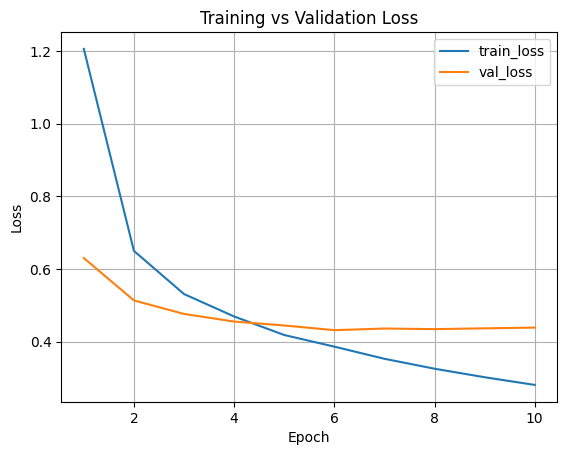

In [ ]:
# Plot losses (single chart)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, label='train_loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 9) Test Inference → answer_test.txt

In [ ]:
# Load test (no labels) and run inference to produce answer_test.txt
if os.path.exists(test_csv):
    test_ds = CondaCsvDataset(test_csv, has_labels=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate)
    model.eval()
    out_lines = []
    with torch.no_grad():
        for x, lens, mask, y_slots, y_int in test_loader:
            slot_logits, intent_logits = model(x, lens, mask)
            ip = intent_logits.argmax(-1).tolist()
            sp = slot_logits.argmax(-1).tolist()
            for i, L in enumerate(lens.tolist()):
                intent = intent_map.itos[ip[i]]
                slots = [slot_map.itos[j] for j in sp[i][:L]]
                out_lines.append(' '.join([intent] + slots))
    ans_path = os.path.join(save_dir, 'answer_test.txt')
    with open(ans_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(out_lines))
    print('Wrote', ans_path, 'with', len(out_lines), 'lines.')
else:
    print('test.csv not found. Set test_csv path to run inference.')

Wrote outputs/answer_test.txt with 8703 lines.


## 10) Download Artifacts

In [ ]:
# Colab-only: download key artifacts
try:
    from google.colab import files  # type: ignore
    for p in ['best.pt','label_maps.json','metrics.json','answer_test.txt']:
        fp = os.path.join(save_dir, p)
        if os.path.exists(fp):
            files.download(fp)
except Exception as e:
    print('files.download not available:', e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>